Simple recurrent neural network (RNN) implementation in Keras using LSTM (long short-term memory) units to identify time of occurence of some events in temporal data based on the wavelet spectrogram of the data

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
#import h5py
import tensorflow
from tensorflow import keras
#from tensorflow.keras.utils import HDF5Matrix

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13244432229437172061
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2556517863577266698
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 916872364489184201
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11269973607
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17859435714615856995
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [4]:
np.random.seed(1234)

# Create training/validation data
Set up some data by superimposing brown noise with with a cosine with Gaussian envelope inserted once at a random time in each dataset

In [5]:
def pink_noise(N):
    """
    Pink noise
    
    Modified from: https://github.com/Eden-Kramer-Lab/ripple_detection
    
    Parameters:
    -----------
    N: int
        number of samples
    
    Returns:
    noise: ndarray
        pink noise signal of length N
    """
    state = np.random.RandomState()
    uneven = N % 2
    X = (state.randn(N // 2 + 1 + uneven) +
         1j * state.randn(N // 2 + 1 + uneven))
    S = np.sqrt(np.arange(len(X)) + 1.0)
    y = (np.fft.irfft(X / S)).real
    if uneven:
        y = y[:-1]
    return y

In [6]:
n_samples = 2000     # number of training + validation datasets
n_val_samples = 50   # number of validation datasets (will use n_val_samples last samples in dataset structure)
signal_length = 1000 # number of time points in segment
dt = 0.001           # s, temporal resolution

# some parameters for the events
impulse_length = 101   # length of impulse label in units of time steps
impulse_freq = 100     # Hz, frequency of impulse
impulse_std = 20       # std. dev of Gaussian
impulse_amplitude = 1. # amplitude of impulse

# Set up labels as boxcars around each event time
y = np.zeros((n_samples, signal_length, 1))
offset = impulse_length // 2 # timesteps
label_width = 51 # timesteps 
times = np.random.randint(offset, signal_length-offset, size=n_samples) # times of events on grid

## create data as pink noise + some oscillatory event at labeled times
X0 = np.zeros((n_samples, signal_length))
for i in range(n_samples):
    X0[i, ] = pink_noise(signal_length)
X0 /= X0.std() # normalize

for i in range(n_samples):
    x = np.zeros(signal_length)
    x[times[i]] = 1
    
    # set up label arrays as boxcars centered on time of events
    y[i, :, 0] = np.convolve(x, ss.boxcar(label_width), 'same')
    
    # compute and superimpose event on background noise
    impulse = ss.gaussian(impulse_length, impulse_std) * \
                          np.cos(impulse_freq*2*np.pi*np.arange(impulse_length)*dt - np.random.rand()*2*np.pi)
    X0[i] = X0[i] + np.convolve(x, impulse*impulse_amplitude, 'same')

# center raw data
X0 = (X0.T - X0.mean(axis=-1)).T

# time vector
time = np.arange(signal_length) * dt

Text(0.5, 0, 't (s)')

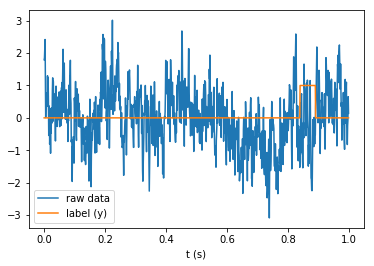

In [7]:
# test plot
plt.figure()
plt.plot(time, X0[0, :], label='raw data')
plt.plot(time, y[0, :, 0], label='label (y)')
plt.legend()
plt.xlabel('t (s)')

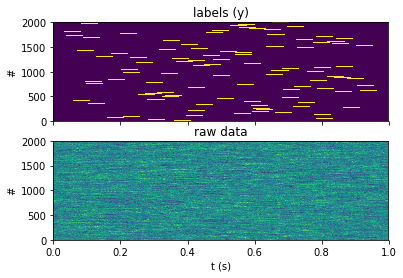

In [8]:
# plot all labels and raw data matrices
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
axes[0].pcolormesh(time, np.arange(n_samples), y[:, :, 0])
axes[0].set_ylabel('#')
axes[0].set_title('labels (y)')
axes[1].pcolormesh(time, np.arange(n_samples), X0)
axes[1].set_ylabel('#')
axes[1].set_xlabel('t (s)')
axes[1].set_title('raw data')
for ax in axes:
    ax.axis(ax.axis('tight'))

In [9]:
# Set up and apply complex morlet wavelet transform of raw data
Fs = 1 / dt # sampling frequency
waveletfreqs = np.arange(25., 200, 10) # Hz

#set up continuous wavelets
w=6.
s=1.

#wavelets
waveletfun = ss.morlet
wavelets = []
for i, f in enumerate(waveletfreqs):
    kwargs = {
        'M' : 2. * s * Fs * w / f,
        'w' : w,
        's' : s,
        'complete' : True,
    }
    wl = waveletfun(**kwargs)
    wavelets.append(wl)

# Container for preprocessed training/validation data
X = np.empty((X0.shape + (waveletfreqs.size,)), dtype=complex)

#apply wavelets
for j, x in enumerate(X0):
    for i, wavelet in enumerate(wavelets):
        X[j, :, i] = ss.convolve(x, wavelet, 'same')

# envelope
X = np.abs(X).astype(float)**2

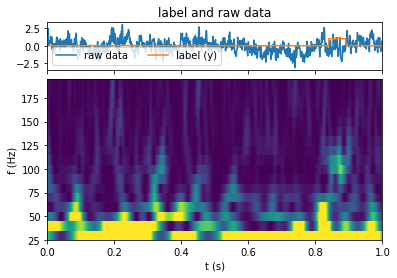

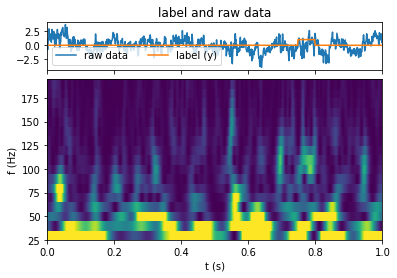

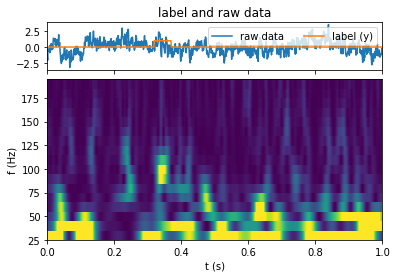

In [10]:
# plot wavelet spectrograms vs. labels and raw data for some samples
for i in range(3):
    gs = GridSpec(4, 1)
    fig = plt.figure()
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(time, X0[i, ], label='raw data')
    ax0.plot(time, y[i, :, 0], label='label (y)' )
    ax0.legend(ncol=2)
    ax0.axis(ax0.axis('tight'))
    ax0.set_title('label and raw data')
    plt.setp(ax0.get_xticklabels(), visible=False)
    
    ax1 = fig.add_subplot(gs[1:, 0], sharex=ax0)
    im = ax1.pcolormesh(time, waveletfreqs, X[i, ].T, vmin=0, vmax=X.std()*2)
    ax1.axis(ax1.axis('tight'))
    ax1.set_ylabel('f (Hz)')
    ax1.set_xlabel('t (s)')

# Set up recurrent neural network

In [11]:
def generate_model(input_shape, lr=0.01, dropout_rate=0.2, layer_sizes=[5, 5, 5], ):
    keras.backend.clear_session()

    # input layer
    inputs = keras.layers.Input(shape=input_shape)
    
    # conv layer
    x = keras.layers.Conv1D(layer_sizes[0], 
                            kernel_size=5, strides=1, 
                            padding='same'
                           )(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    
    # LSTM layer 1
    x = keras.layers.LSTM(layer_sizes[1], return_sequences=True)(x)
    x = keras.layers.BatchNormalization()(x)  
    x = keras.layers.Dropout(dropout_rate)(x)
    
    # LSTM layer 2
    x = keras.layers.LSTM(layer_sizes[2], return_sequences=True)(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
        
    # dense output layer
    predictions = keras.layers.TimeDistributed(
        keras.layers.Dense(1, activation='sigmoid'))(x)
    
    # Define model
    model = keras.models.Model(inputs=inputs, outputs=predictions)

    opt = keras.optimizers.Adam(lr=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', 'mse'])

    return model

In [12]:
model = generate_model(input_shape=X[0].shape)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000, 18)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1000, 5)           455       
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 5)           20        
_________________________________________________________________
activation (Activation)      (None, 1000, 5)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1000, 5)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1000, 5)           220       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 5)           20    

In [14]:
history = model.fit(X[:-n_val_samples, :, :], y[:-n_val_samples, :, :], 
                    batch_size=20, epochs=20, 
                    validation_data=(X[-n_val_samples:, :, :], y[-n_val_samples:, :, :]))

Train on 1950 samples, validate on 50 samples
Epoch 1/20
1950/1950 [==============================] - 32s 16ms/sample - loss: 0.3004 - accuracy: 0.9106 - mse: 0.0863 - val_loss: 0.1935 - val_accuracy: 0.9490 - val_mse: 0.0478
Epoch 2/20
1950/1950 [==============================] - 24s 12ms/sample - loss: 0.0942 - accuracy: 0.9716 - mse: 0.0227 - val_loss: 0.2018 - val_accuracy: 0.9490 - val_mse: 0.0485
Epoch 3/20
1950/1950 [==============================] - 24s 12ms/sample - loss: 0.0861 - accuracy: 0.9724 - mse: 0.0216 - val_loss: 0.1525 - val_accuracy: 0.9490 - val_mse: 0.0430
Epoch 4/20
1950/1950 [==============================] - 24s 12ms/sample - loss: 0.0813 - accuracy: 0.9739 - mse: 0.0204 - val_loss: 0.1243 - val_accuracy: 0.9531 - val_mse: 0.0352
Epoch 5/20
1950/1950 [==============================] - 24s 12ms/sample - loss: 0.0792 - accuracy: 0.9741 - mse: 0.0201 - val_loss: 0.0733 - val_accuracy: 0.9720 - val_mse: 0.0205
Epoch 6/20
1950/1950 [==============================] 

[]

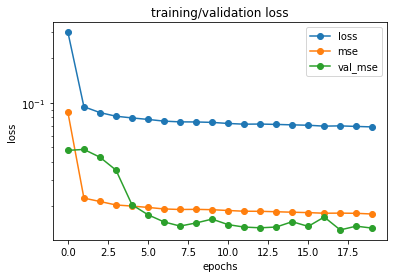

In [15]:
plt.figure()
plt.semilogy(history.history['loss'], '-o', label='loss')
#plt.plot(history.history['accuracy'], '-o', label='accuracy')
#plt.plot(history.history['val_accuracy'], '-o', label='val_accuracy')
plt.semilogy(history.history['mse'], '-o', label='mse')
plt.semilogy(history.history['val_mse'], '-o', label='val_mse')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('training/validation loss')
plt.semilogy()

Text(0.5, 0, '$t$ (s)')

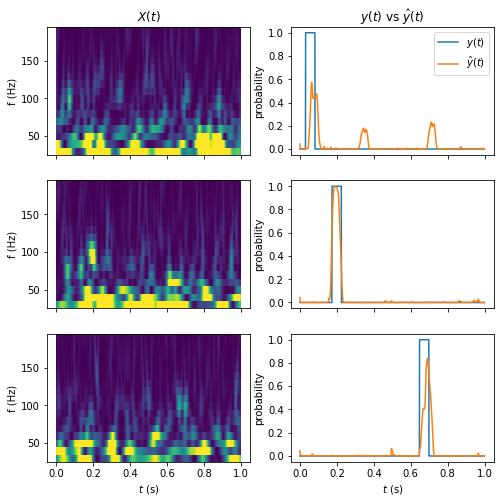

In [16]:
# visualize predictions on some samples from the validation set
#n_val_samples = 3
n_plots = 3
X_val = X[-n_val_samples:, ]
y_val = y[-n_val_samples:, ]

y_pred = model.predict(X_val)

# compare prediction to ground truth
fig, axes = plt.subplots(n_plots, 2, figsize=(8, 8), 
                         sharex=True, sharey='col')
for i in range(n_plots):
    axes[i, 0].pcolormesh(time, waveletfreqs, X_val[i].T, vmin=0, vmax=X.std()*2)
    axes[i, 1].plot(time, y_val[i], label='$y(t)$')
    axes[i, 1].plot(time, y_pred[i], label='$\hat{y}(t)$')
    if i == 0:
        axes[i, 1].legend()
        axes[i, 0].set_title('$X(t)$')
        axes[i, 1].set_title('$y(t)$ vs $\hat{y}(t)$')
    axes[i, 0].set_ylabel('f (Hz)')
    axes[i, 1].set_ylabel('probability')
axes[i, 0].set_xlabel('$t$ (s)')
axes[i, 1].set_xlabel('$t$ (s)')